# Crypto EDA

## Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
import os


## Some functions

In [43]:
def calculate_drawdown(prices):
    """Calculate drawdown series"""
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax * 100
    return drawdown

## Load daily Data (10 years)

In [2]:
data_path = ('/Users/alena/ms_ox/crypto_cpd/data/') 

pairs = ['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'ADA', 'DOGE', 'AVAX', 'DOT', 'MATIC']
daily_data = {}

for pair in pairs:
    file = data_path + f'{pair}_USDT_daily_10y.parquet'
    if os.path.exists(file):
        df = pd.read_parquet(file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        daily_data[pair] = df
        
print(f"Loaded {len(daily_data)} pairs")
print(f"Date range: {daily_data['BTC'].index.min()} to {daily_data['BTC'].index.max()}")

Loaded 10 pairs
Date range: 2017-08-17 00:00:00 to 2026-02-12 00:00:00


# Summary Statistics

In [42]:
# Daily stats for all pairs
summary = []
for pair in pairs:
    rets = daily_data[pair]['returns'].dropna()
    summary.append({
        'Pair': pair,
        'Mean Return (%)': rets.mean() * 100 * 365,
        'Volatility (%)': rets.std() * np.sqrt(365) * 100,
        'Sharpe': rets.mean() / rets.std() * np.sqrt(365),
        'Max Drawdown (%)': calculate_drawdown(daily_data[pair]['close']).min(),
        'Skewness': rets.skew(),
        'Kurtosis': rets.kurtosis()
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.round(2)
summary_df.sort_values('Sharpe', ascending=False, inplace=True)

print("\n=== Daily Stats Summary (10 years) ===")
print(summary_df.to_string(index=False))


=== Daily Stats Summary (10 years) ===
 Pair  Mean Return (%)  Volatility (%)  Sharpe  Max Drawdown (%)  Skewness  Kurtosis
MATIC           179.86          145.83    1.23            -87.97      1.74     14.53
  BNB           118.97           99.05    1.20            -80.02      2.06     28.78
  SOL           127.83          119.01    1.07            -96.27      0.59      6.31
  BTC            55.94           68.40    0.82            -83.19     -0.23      8.50
 DOGE           150.89          195.23    0.77            -92.33     24.26    903.68
  ETH            61.35           88.08    0.70            -93.97     -0.16      6.35
 AVAX            78.71          119.34    0.66            -93.83      1.18     12.65
  XRP            56.60          103.53    0.55            -84.99      2.17     25.81
  ADA            52.10          102.23    0.51            -93.74      1.16     15.37
  DOT            36.77          104.10    0.35            -97.68      1.09     11.85


## Price dynamics

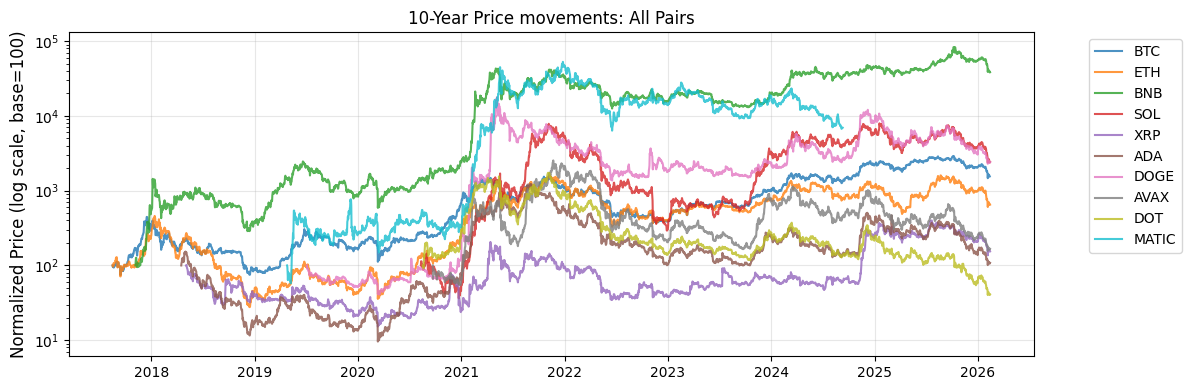

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

for pair in pairs:
    normalized = (daily_data[pair]['close'] / daily_data[pair]['close'].iloc[0]) * 100
    ax.plot(normalized.index, normalized, label=pair, linewidth=1.5, alpha=0.8)

ax.set_yscale('log')
ax.set_ylabel('Normalized Price (log scale, base=100)', fontsize=12)
ax.set_title('10-Year Price movements: All Pairs')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# common behaviou
# 1) 2021 bull run
# 2) 2022 bear market
# But: 2018-2020, 2023: coins spread apart, more idiosyncratic behavior



# Returns & Volatility 

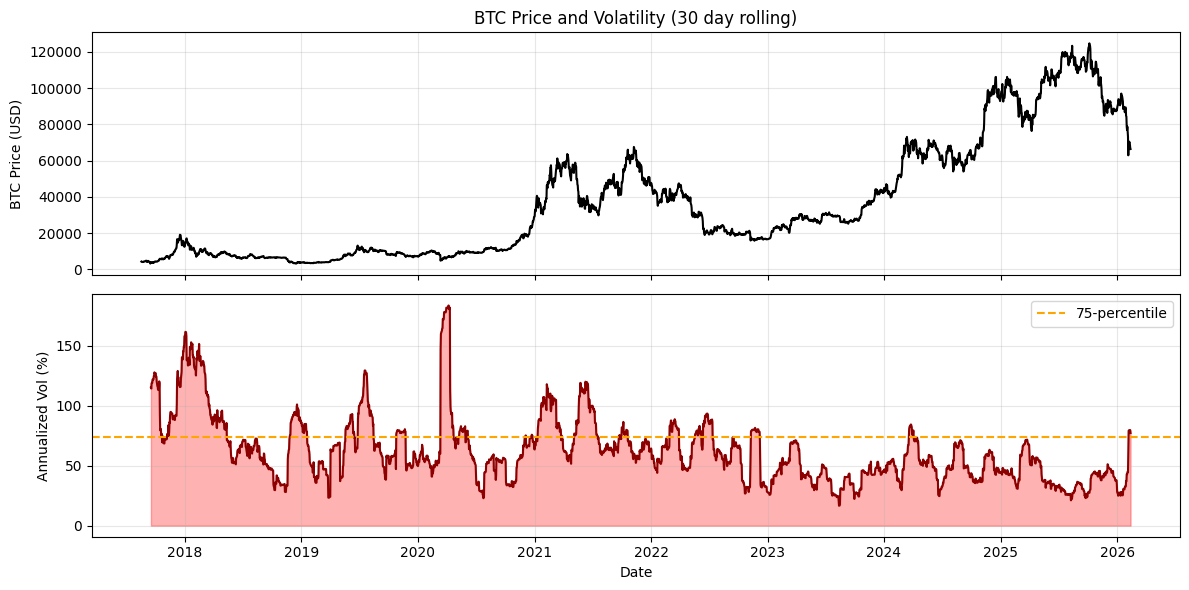


Volatility stats (BTC):
Mean: 62.3%
Median: 56.8%
Q3 (high vol threshold): 73.7%


In [14]:
# returns
for pair in pairs:
    daily_data[pair]['returns'] = daily_data[pair]['close'].pct_change()

# BTC rolling volatility with 30-day window
btc_vol = daily_data['BTC']['returns'].rolling(30).std() * np.sqrt(365) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# price with volatility regimes
ax1.plot(daily_data['BTC'].index, daily_data['BTC']['close'], color='black', linewidth=1.5)
ax1.set_ylabel('BTC Price (USD)')
ax1.set_title('BTC Price and Volatility (30 day rolling)')
ax1.grid(True, alpha=0.3)

# volatility
ax2.fill_between(btc_vol.index, btc_vol, alpha=0.3, color='red')
ax2.plot(btc_vol.index, btc_vol, color='darkred', linewidth=1.5)
ax2.axhline(btc_vol.quantile(0.75), color='orange', linestyle='--', label='75-percentile')
ax2.set_ylabel('Annualized Vol (%)')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVolatility stats (BTC):")
print(f"Mean: {btc_vol.mean():.1f}%")
print(f"Median: {btc_vol.median():.1f}%")
print(f"Q3 (high vol threshold): {btc_vol.quantile(0.75):.1f}%")

# Cross-asset correlations

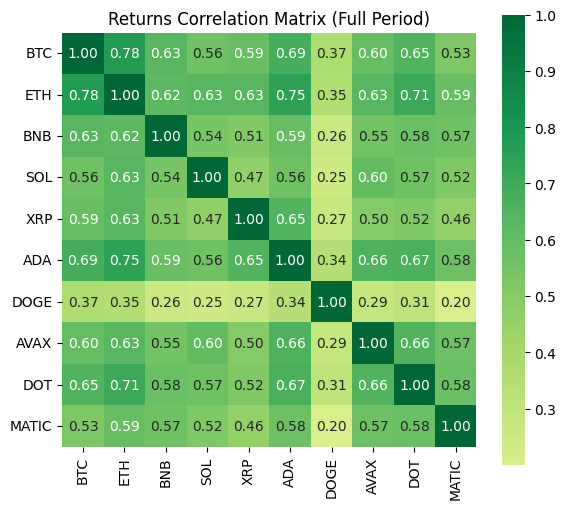

In [ ]:
returns_df = pd.DataFrame({pair: daily_data[pair]['returns'] for pair in pairs})
corr_matrix = returns_df.corr()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            square=True, 
            cbar_kws={"shrink": 0.8}
            )
ax.set_title('Returns Correlation Matrix (Full Period)')
plt.tight_layout()
plt.show()

#  I can check correlations in different sub-periods
# correlation can be a regime indicator - if BTC correlation drops, maybe we are in a more idiosyncratic regime?

##  Rolling Correlation: BTC vs Others
Useful for detecting regime shifts where correlations break down

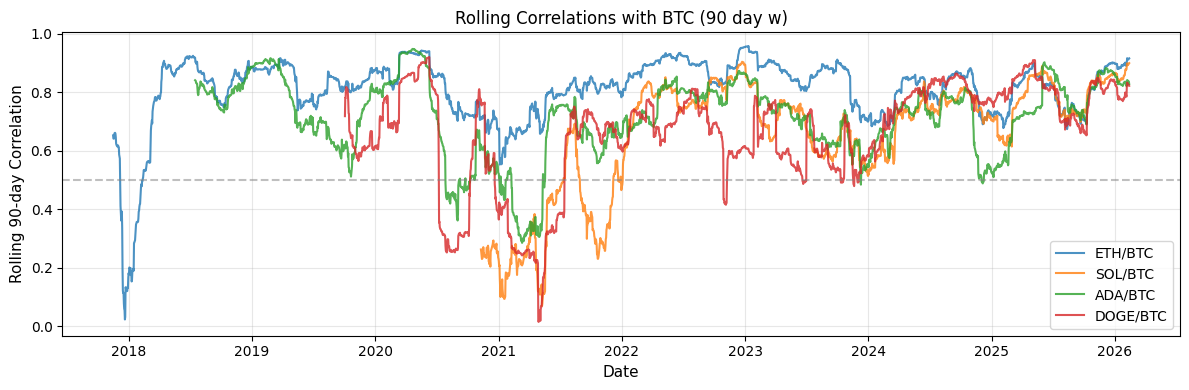

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))

for pair in ['ETH', 'SOL', 'ADA', 'DOGE']:
    roll_corr = returns_df['BTC'].rolling(90).corr(returns_df[pair])
    ax.plot(roll_corr.index, roll_corr, label=f'{pair}/BTC', linewidth=1.5, alpha=0.8)

ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Rolling 90-day Correlation', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_title('Rolling Correlations with BTC (90 day w)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Drawdown Analysis (Worst Windows)
Inspired by DeePM paper - focus on worst periods

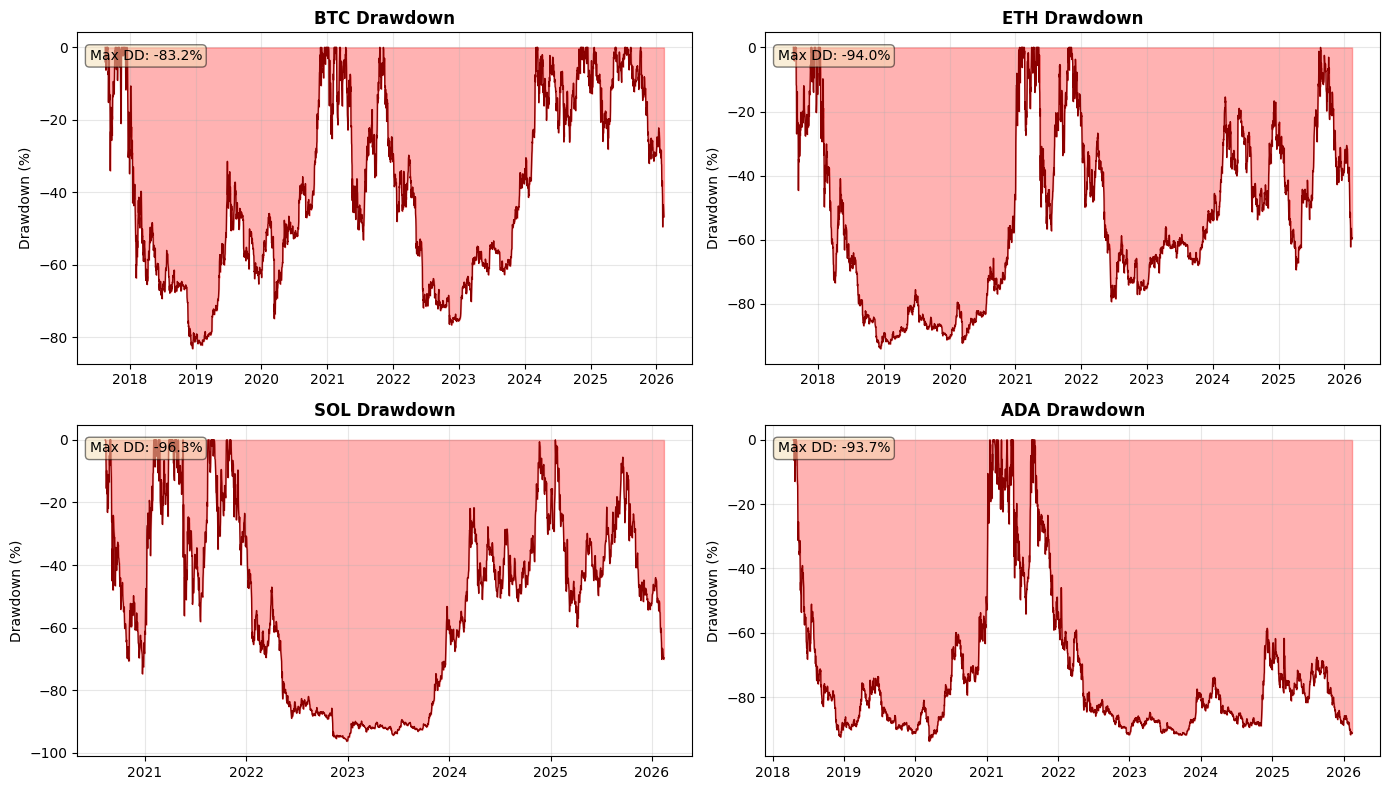

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, pair in enumerate(['BTC', 'ETH', 'SOL', 'ADA']):
    dd = calculate_drawdown(daily_data[pair]['close'])
    axes[i].fill_between(dd.index, dd, 0, alpha=0.3, color='red')
    axes[i].plot(dd.index, dd, color='darkred', linewidth=1)
    axes[i].set_title(f'{pair} Drawdown', fontweight='bold')
    axes[i].set_ylabel('Drawdown (%)')
    axes[i].grid(True, alpha=0.3)
    
    max_dd = dd.min()
    axes[i].text(0.02, 0.95, f'Max DD: {max_dd:.1f}%', 
                transform=axes[i].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Returns Distribution & Fat Tails

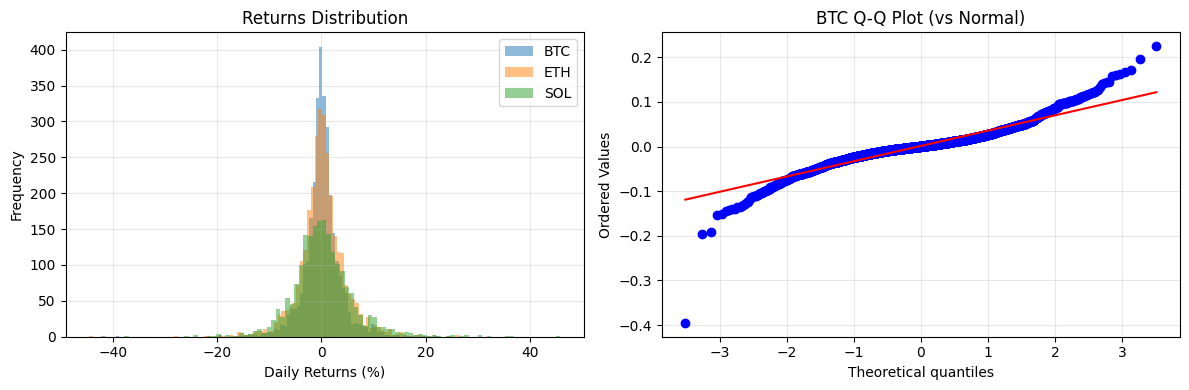


BTC Returns stats:
Skewness: -0.23
Kurtosis: 8.50 (excess)


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for pair in ['BTC', 'ETH', 'SOL']:
    axes[0].hist(daily_data[pair]['returns'].dropna() * 100, bins=100, alpha=0.5, label=pair)
axes[0].set_xlabel('Daily Returns (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Returns Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

btc_returns = daily_data['BTC']['returns'].dropna()
stats.probplot(btc_returns, dist="norm", plot=axes[1])
axes[1].set_title('BTC Q-Q Plot (vs Normal)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBTC Returns stats:")
print(f"Skewness: {btc_returns.skew():.2f}")
print(f"Kurtosis: {btc_returns.kurtosis():.2f} (excess)")

## Minute Data (BTC only)

In [32]:
minute_file = data_path +  'BTC_USDT_1m_20260207_20260212.parquet'
btc_1m = pd.read_parquet(minute_file)
btc_1m['timestamp'] = pd.to_datetime(btc_1m['timestamp'])
btc_1m.set_index('timestamp', inplace=True)
btc_1m['returns'] = btc_1m['close'].pct_change()

print(f"Minute data: {btc_1m.index.min()} to {btc_1m.index.max()}")
print(f"Total minutes: {len(btc_1m):,}")

Minute data: 2026-02-07 00:00:00 to 2026-02-12 00:00:00
Total minutes: 7,201


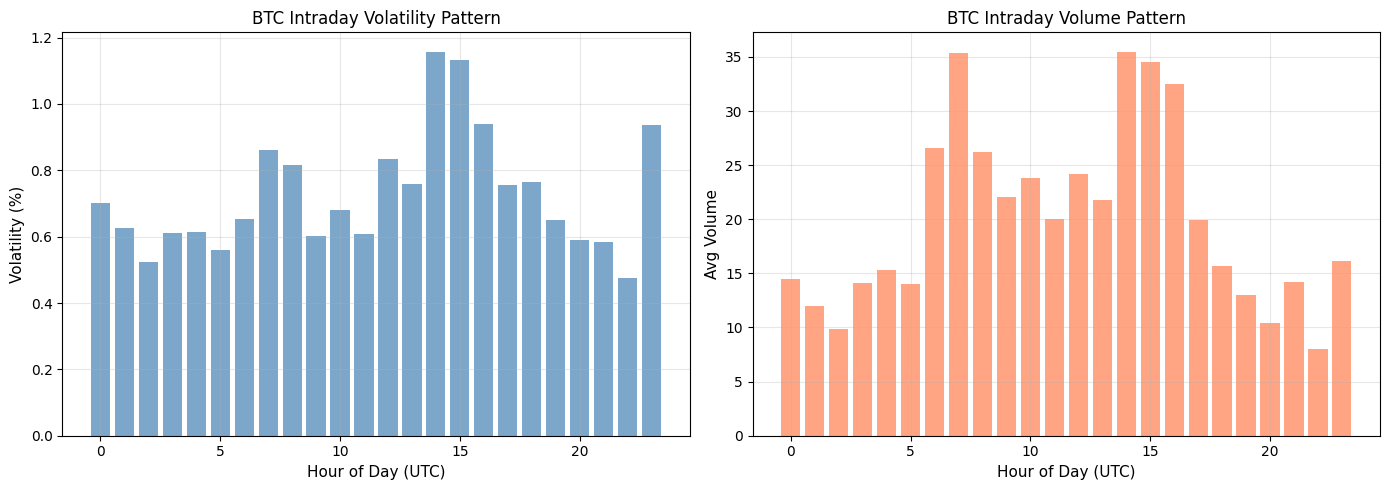

In [44]:
# Intraday volatility pattern
btc_1m['hour'] = btc_1m.index.hour
hourly_vol = btc_1m.groupby('hour')['returns'].std() * np.sqrt(60) * 100  # annualized hourly vol

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hourly volatility pattern
ax1.bar(hourly_vol.index, hourly_vol, color='steelblue', alpha=0.7)
ax1.set_xlabel('Hour of Day (UTC)', fontsize=11)
ax1.set_ylabel('Volatility (%)', fontsize=11)
ax1.set_title('BTC Intraday Volatility Pattern')
ax1.grid(True, alpha=0.3)

# Volume pattern
hourly_vol_usd = btc_1m.groupby('hour')['volume'].mean()
ax2.bar(hourly_vol_usd.index, hourly_vol_usd, color='coral', alpha=0.7)
ax2.set_xlabel('Hour of Day (UTC)', fontsize=11)
ax2.set_ylabel('Avg Volume', fontsize=11)
ax2.set_title('BTC Intraday Volume Pattern')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Autocorrelation Check 

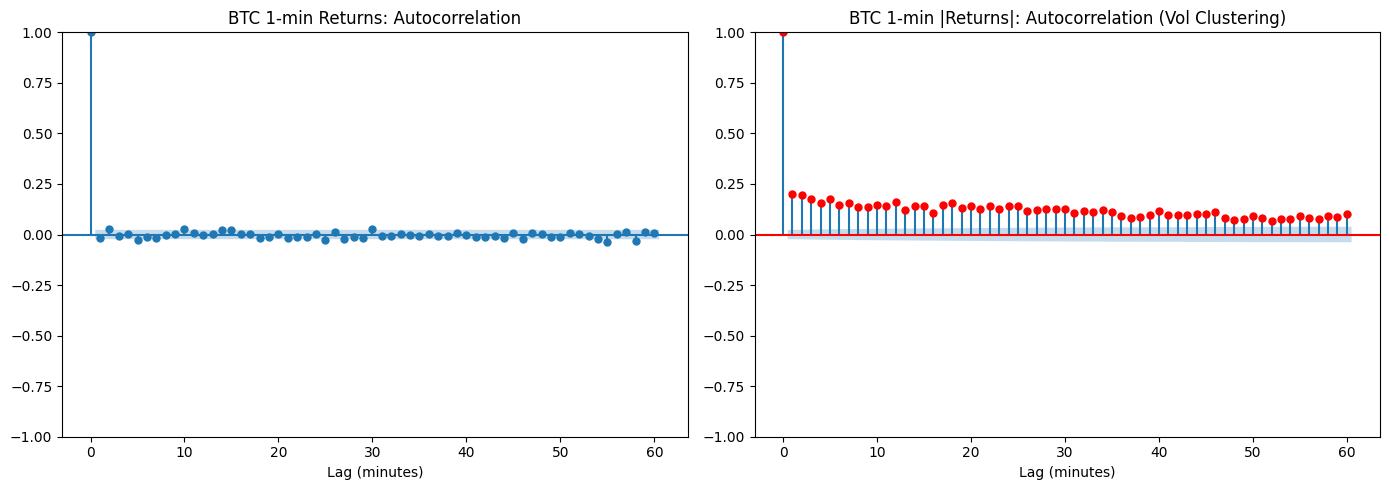

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(btc_1m['returns'].dropna(), lags=60, ax=ax1, alpha=0.05)
ax1.set_title('BTC 1-min Returns: Autocorrelation')
ax1.set_xlabel('Lag (minutes)')

plot_acf(btc_1m['returns'].abs().dropna(), lags=60, ax=ax2, alpha=0.05, color='red')
ax2.set_title('BTC 1-min |Returns|: Autocorrelation (Vol Clustering)')
ax2.set_xlabel('Lag (minutes)')

plt.tight_layout()
plt.show()